In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, mean_squared_error, mean_absolute_error, r2_score

In [0]:
# Метод визулизации дерева в формате PNG
# необходимо для иллюстрации больших деревьев
from IPython.display import Image
from sklearn.externals.six import StringIO 
import pydotplus
from sklearn.tree import export_graphviz
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True,
                    class_names=['Low', 'Middle', 'High'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [0]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = {'1': 'Low chances', '2':'Middle chances','3': 'High chances'}
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for key in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==int(key)]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[classes[key]] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t\t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [0]:
# Метод оценки качества модели классификации
def classificationMetrics(y_test, y_predicted):
  print('F1: \t\t', f1_score(y_true= y_test, y_pred= y_predicted, average= 'weighted'))
  print('MSE: \t\t',mean_squared_error(y_true= y_test, y_pred= y_predicted) )
  print_accuracy_score_for_classes(y_true= y_test, y_pred= y_predicted)

In [0]:
# Метод оценки качества модели регрессии
def regressionMetrics(y_test, y_predicted):
  print('MSE: \t', mean_squared_error(y_test, y_predicted))
  print('MAE: \t', mean_absolute_error(y_test, y_predicted))
  print('R2: \t', r2_score(y_true=np.array(y_test), y_pred=y_predicted ))

In [0]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(10,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
        
    plt.show()
    return labels, data

**Цель лабораторной работы:** изучение ансамблей моделей машинного обучения.

#Первичная обработка датасета
Урезанная версия датасета использовалась для анализа в РК№1, в данной  лабораторной используется датасет, содержащий на 100 наблюдений больше. Различия между версиями заключалется только в количестве наблюдений, поэтому информация о всех остальных особенностях датасета зараннее известна:

* В датасете отсутствуют пробелы;
* В названиях двух колонок присутствуют пробелы, которые  необходимо будет убрать;

In [0]:
data1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ММО/6/Admission_Predict_Ver1.1.csv', sep=',')

In [0]:
strippedCols = dict()
for name in data1.columns:
  strippedCols[name] = name.strip() 
data1 = data1.rename(strippedCols, axis='columns', errors='raise')
data1.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


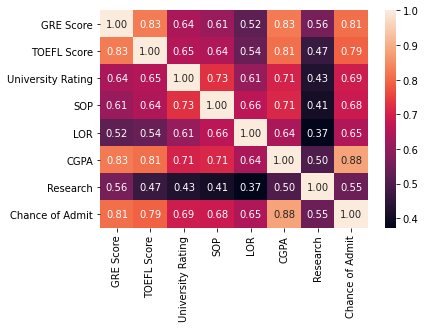

In [0]:
import seaborn as sbrn
sbrn.heatmap(data1[data1.columns[1:]].corr(), annot=True, fmt='.2f')

Данный датасет предназначен для прогнозирования приема выпускников. Большая часть переменных соответствует значениям личных достижений кандидатов. Переменная `Chace of Admit` характеризует шансы кандидата на поступление.

**Основные задачи**

* *Классификация* - Опеределить группу шансов кандидата (`low chances`, `middle chances`, `high chances` - - низкие, средние и высокие шансы на поступление) по результатам его личных достижений. Модель для решения поставленной задачи - `RandomForestClassifier`
* *Регрессия* - Определить шансы кандидата на поступление (`Chance of Admit`) по результатам его личных достижений. Модель для решения поставленной задачи -  `AdaBoostRegression`

**Подготовка датасета для решения задачи классификации**

Для того , чтобы приступить к решению задачи, необходимо выполнить разделение данных по классам. Будут выделены 3 следующих класса:
* low chances - низкие шансы на поступление ( до 0.6 `Chance of Admit`)
* middle chances - средние шансы на поступление ( от 0.6 до 0.8 `Chance of Admit`)
* high chances - высокие шансы на поступление (0ю8 и выше `Chance of Admit`)

In [0]:
# Метод создания переменной класса
def createClassification( bottomLimit, middleLimit ):
  classes = []
  for val in data1['Chance of Admit'].values:
    if val <= bottomLimit:
      classes.append(1)
    else:
       if val <= middleLimit:
        classes.append(2)
       else:
        classes.append(3)
  return pd.DataFrame(data= np.c_[data1, classes], columns= np.append(data1.columns.values, 'Class'))

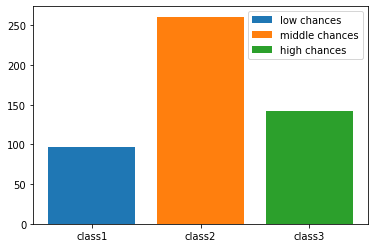

In [0]:
data2 = createClassification(0.6, 0.8)
ax0 = plt.subplot()
class1 = data2[data2['Class']==1].shape[0]
class2 = data2[data2['Class']==2].shape[0]
class3 = data2[data2['Class']==3].shape[0]
ax0.bar( 'class1', class1, label='low chances')
ax0.bar( 'class2', class2, label='middle chances')
ax0.bar( 'class3', class3, label='high chances')
ax0.legend()
plt.show()

In [0]:
print('Распределение данных по классам')
print('Low chances :', round(data2[data2['Class'] == 1].shape[0]/data2.shape[0] * 100, 2), '%')
print('Middle chances :',  round(data2[data2['Class'] == 2].shape[0]/data2.shape[0] * 100, 2), '%')
print('High chances :',  round(data2[data2['Class'] == 3].shape[0]/data2.shape[0] * 100, 2), '%')

Распределение данных по классам
Low chances : 19.4 %
Middle chances : 52.2 %
High chances : 28.4 %


Распределение показало, что ~50% кандидатов на поступление имеют средние шансы, ~20% малые, а ~30% высокие. Теперь можно перейти к решению задачи классификации.

#Случайный лес (классификация)

**Разделение данных**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data2.loc[:, 'GRE Score':'Research'], \
                                                   data2['Class'], \
                                                   test_size=0.3, \
                                                   random_state=15)

**Построение тестовой модели**

Для тестовой модели, деревья, входящие в состав случайного леса, будут строиться со следующими гиперпараметрами:

* `max_depth` = 5
* `max_features` = 0.2
* `min_samples_leaf` = 0.04

Кол-во деревьев в случайном лесу - 5


In [0]:
from sklearn.ensemble import RandomForestClassifier
tree1 = RandomForestClassifier(n_estimators=5, oob_score=True, random_state=10, max_depth=5, max_features=0.2, min_samples_leaf=0.04)
tree1.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning:

invalid value encountered in true_divide



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=0.2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.04, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)

Оценка среднего OOB

In [0]:
# Out-of-bag error, возвращаемый классификатором
tree1.oob_score_, 1-tree1.oob_score_

(0.7514285714285714, 0.24857142857142855)

Таким образом, построенная модель случайного леса охватывает порядка 75% обучающей выборки.

**Оценка качества тестовой модели**

In [0]:
tree1Prediction = tree1.predict(X_test)
classificationMetrics(y_test, tree1Prediction)

F1: 		 0.7616655954815464
MSE: 		 0.23333333333333334
Метка 		 Accuracy
Low chances 	 0.5
Middle chances 	 0.9014084507042254
High chances 	 0.7169811320754716


**Поиск лучшей модели**

Для поиска наиболее оптимальной модели необходимо осуществить подбор гиперпараметров.

In [0]:
# Набор параметров для поиска лучшей модели
params = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [0.02, 0.04, 0.06, 0.08],
    'max_features': [0.2, 0.4, 0.6, 0.8]
} 

Таким образом, при поиске наилучшей модели будут варьироваться следующие параметры:

* `max_depth` - максимальная глубина деревьев в случайном лесу
* `min_samples_leaf` - минимальный предел записей для выделения листов в деревьях.
* `max_features` - коэффициент для функции ветвления.

In [0]:
# Подготовка моделей и обучение с различными комбинациями параметров
randomForestArray = []
for m_d in params['max_depth']:
  for m_s_l in params['min_samples_leaf']:
    for m_f in params['max_features']:
      temp_tree = RandomForestClassifier(n_estimators=5, \
                                                      oob_score=True, \
                                                      random_state=10, \
                                                      max_depth=m_d, \
                                                      max_features= m_f, \
                                                      min_samples_leaf=m_s_l)
      temp_tree.fit(X_train, y_train)
      randomForestArray.append(temp_tree)

In [0]:
# Сбор результатов по моделям. 
# Метрика для оценки качества - mean_squared_error . 
def fitAndTrain(model):
  modelPrediction = model.predict(X_test)
  return {'model':model,
          'modelPrediction':modelPrediction,
          'MSE':mean_squared_error(y_true=y_test, y_pred=modelPrediction)}

randomForestAccuracy = list( map( fitAndTrain,randomForestArray))


In [0]:
# Отбор лучшей модели по MSE
minMSE = {'model':{},'modelPrediction':{}, 'MSE': 1. }
for obs in randomForestAccuracy:
  if minMSE['MSE'] > obs['MSE']:
    minMSE = obs

minMSE['model']

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features=0.6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.04, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)

В результате перебора гиперпараметров, была найдена наиболее оптимальная модель со следующими гиперпараметрами:

* `max_depth`  = 3
* `min_samples_leaf` = 0.04
* `max_features` = 0.6

**Сравнение тестовой и лучшей модели**

Для сравнения качества резльтатов работы модели используются основные метрики качества  моделей классификации: F1, среднее квадратическое отклонение ошибки, а также точности определения каждого класса. 

In [0]:
print('Test model: ')
classificationMetrics(y_test, tree1Prediction)
print('\nBest model: ')
classificationMetrics(y_test, minMSE['modelPrediction'])

Test model: 
F1: 		 0.7616655954815464
MSE: 		 0.23333333333333334
Метка 		 Accuracy
Low chances 	 0.5
Middle chances 	 0.9014084507042254
High chances 	 0.7169811320754716

Best model: 
F1: 		 0.7966200887719875
MSE: 		 0.2
Метка 		 Accuracy
Low chances 	 0.5384615384615384
Middle chances 	 0.9014084507042254
High chances 	 0.7924528301886793


Таким образом, наиболее оптимальная модель имеет меньшее СКО  на 0.034 в сравнении с тестовой моделью, более точчное определение классов, хоть и определение кандидатов с низкими шансами на поступление оставляет желать лучшего.

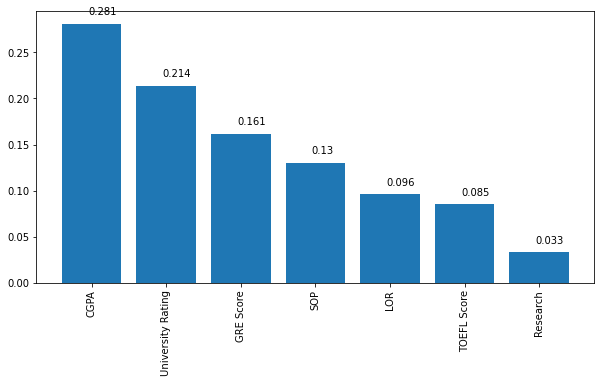

In [0]:
_,_ = draw_feature_importances(tree1, data2.loc[:, 'GRE Score':'Research'])

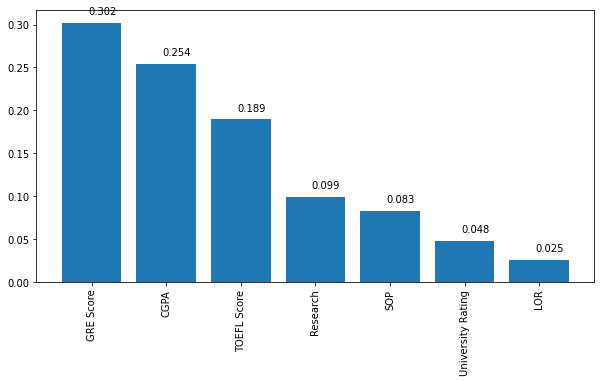

In [0]:
_,_ = draw_feature_importances(minMSE['model'], data2.loc[:, 'GRE Score':'Research'])

Распределение значимости переменных при построении деревьев показало, что для тестовой и оптимальной модели использовались одни и те же переменные, но с разными пропорциями значимости.

Деревья, входящие в состав оптимальной модели:

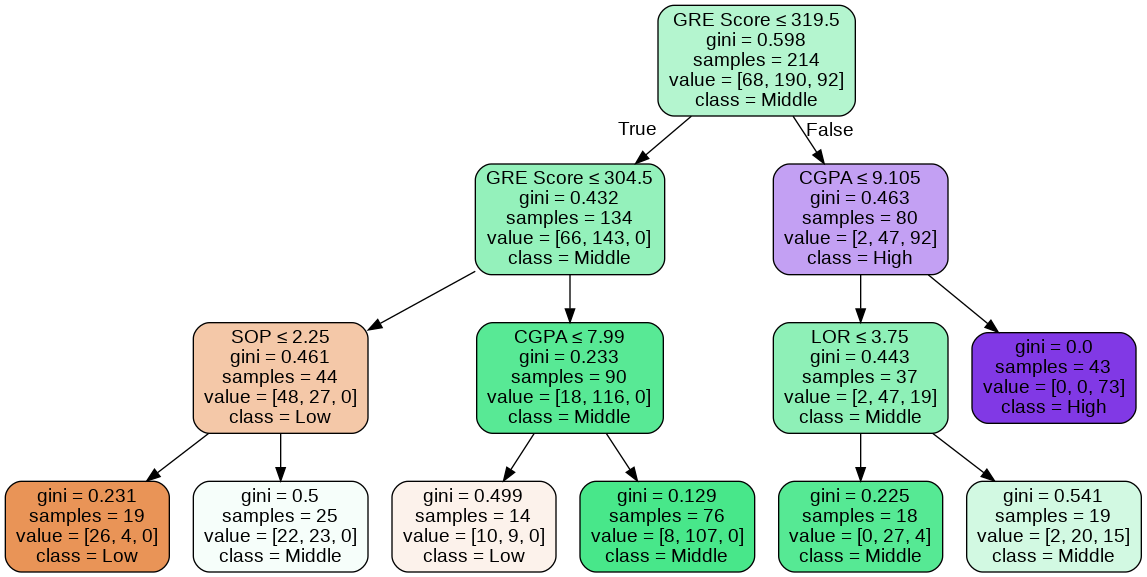

In [0]:
Image(get_png_tree(minMSE['model'].estimators_[0], np.array(data2.loc[:, 'GRE Score':'Research'].columns)), height="250")

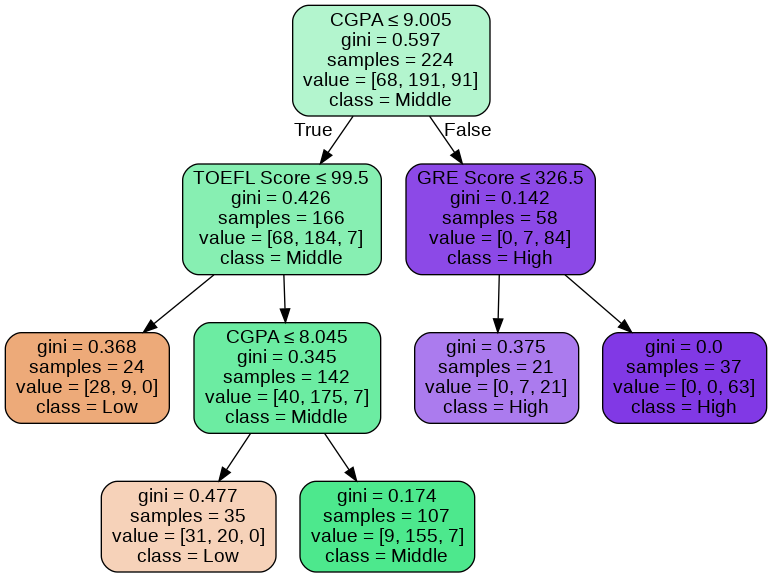

In [0]:
Image(get_png_tree(minMSE['model'].estimators_[1], np.array(data2.loc[:, 'GRE Score':'Research'].columns)), height="250")

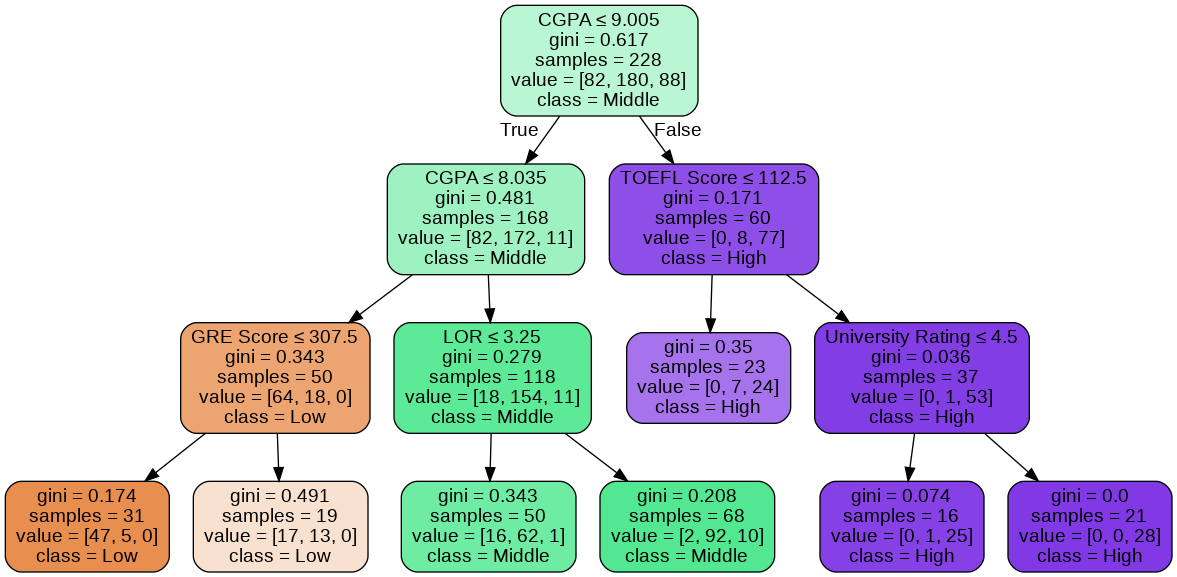

In [0]:
Image(get_png_tree(minMSE['model'].estimators_[2], np.array(data2.loc[:, 'GRE Score':'Research'].columns)), height="250")

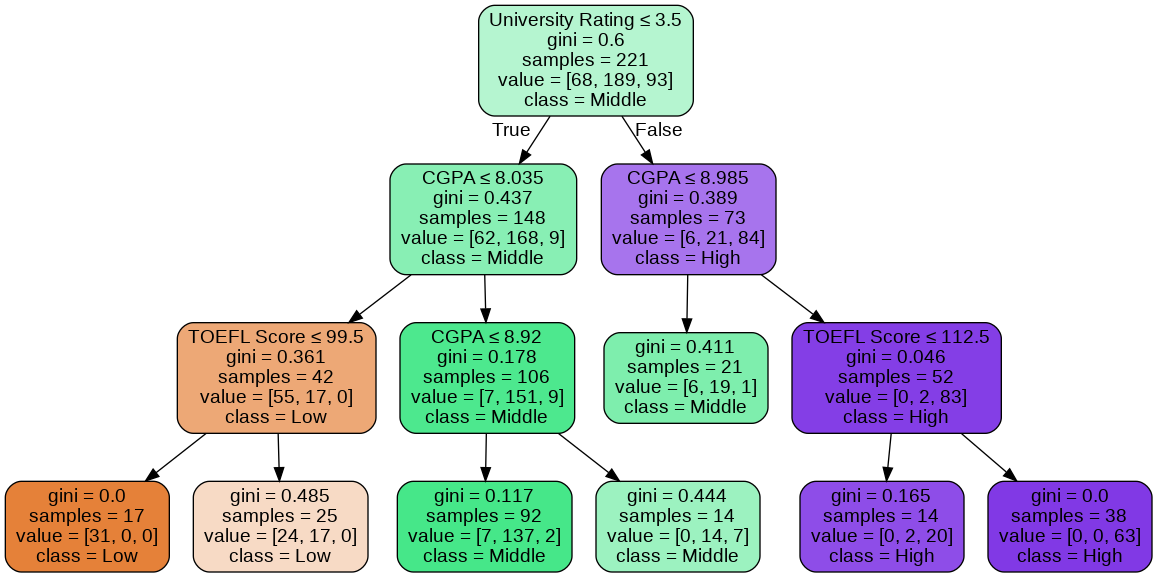

In [0]:
Image(get_png_tree(minMSE['model'].estimators_[3], np.array(data2.loc[:, 'GRE Score':'Research'].columns)), height="250")

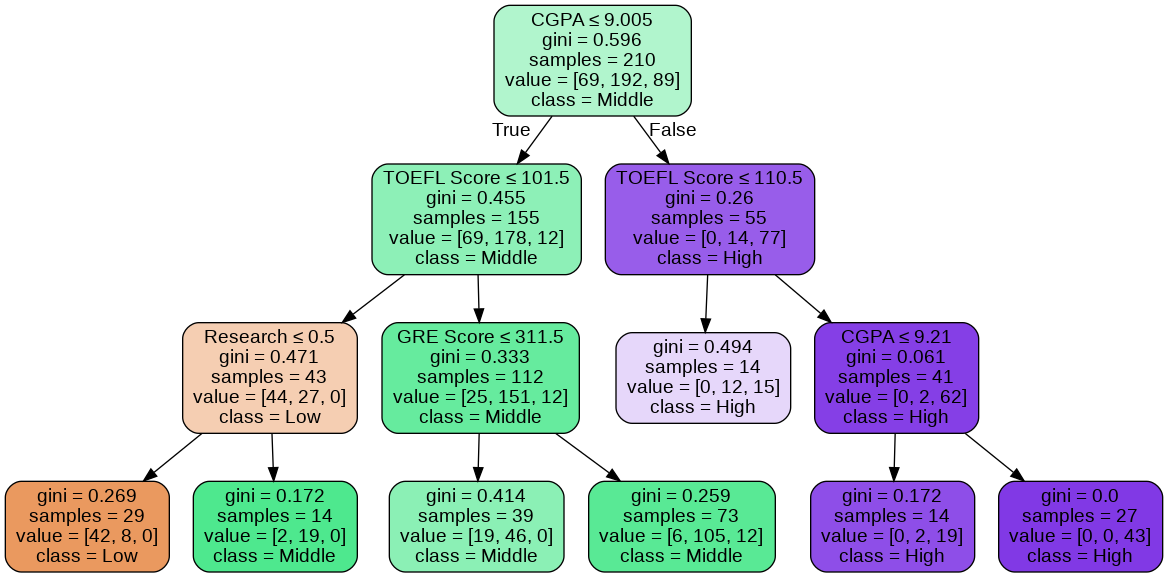

In [0]:
Image(get_png_tree(minMSE['model'].estimators_[4], np.array(data2.loc[:, 'GRE Score':'Research'].columns)), height="250")

**Вывод:** В результате подбора гиперпараметра была подобрана наиболее оптимальная модель, однако для решения поставленной задачи, точность определения классов оставляет желать лучшего. 

#AdaBoost (регрессия)

Для решения поставленной задачи была выбрана ансамблиевая мдель AdaBoostRegressor. Суть работы модели заключается в оптимизации базовых "слабых" моделей посредством градиентного бустинга.

**Построение тестовой модели**

Тестовая модель будет строиться на базовых моделях со следующими параметрами: 
* `max_depth` = 3
* `min_samples_leaf` = 1
* `max_features` = 1

Все модели AdaBoost будут строиться с параметром `n_estimators` = 5

In [0]:
from sklearn.tree import DecisionTreeRegressor
DTR = DecisionTreeRegressor(max_depth=3, min_samples_leaf=1, max_features=1)

In [0]:
# Разделение выборки для решения задачи классификации
X_train, X_test, y_train, y_test = train_test_split(data2.loc[:, 'GRE Score':'Research'], \
                                                   data2['Chance of Admit'], \
                                                   test_size=0.3, \
                                                   random_state=15)

Также в тестовой модели используется гиперпараметр `loss`, отвечающий за функцию потерь.

* `loss` = square

In [0]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
ab1 = AdaBoostRegressor( base_estimator=DTR, n_estimators=5, loss='square' )
ab1.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=3,
                                                       max_features=1,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                  lea

Рассмотрим оценки качества полученной модели. Для этого используются основные метрики для оценки качества регрессии: СКО, средняя абсолютная ошибка и R1

In [0]:
ab1Predictions = ab1.predict(X_test)
regressionMetrics(y_test, ab1Predictions)

MSE: 	 0.006950148845885197
MAE: 	 0.06383169142078847
R2: 	 0.6361554523920812


Оценки регрессии показали хорошие результаты - низкое СКО и показатель средней абсолютной ошибки.

Необходимо улучшить качество модели, для этого стоит задача выполнить перебор гиперпараметров для построения модели.

**Поиск наиболее оптимальной модели**

Алгоритм подобен алгоритму, примененному при поиске лучшей модели классификации.

In [0]:
# Набор параметров для поиска лучшей модели
params = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [0.02, 0.04, 0.06, 0.08],
    'max_features': [0.2, 0.4, 0.6, 0.8],
    'lossParameters': ['linear', 'square', 'exponential']
} 

In [0]:
adaBoostModels = []
for m_d in params['max_depth']:
  for m_s_l in params['min_samples_leaf']:
    for m_f in params['max_features']:
      for l_p in params['lossParameters']:
        temp_tree = DecisionTreeRegressor(max_depth=m_d, \
                                          max_features= m_f, \
                                          min_samples_leaf=m_s_l)
        tempAB = AdaBoostRegressor( base_estimator=temp_tree, n_estimators=5, loss=l_p )
        tempAB.fit(X_train, y_train)
        adaBoostModels.append(tempAB)

In [0]:
adaBoostTrained = list( map( fitAndTrain,adaBoostModels))
minMSE = {'model':{},'modelPrediction':{}, 'MSE': 1. }
for obs in adaBoostTrained:
  if minMSE['MSE'] > obs['MSE']:
    minMSE = obs

minMSE['model']

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=6,
                                                       max_features=0.4,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=0.04,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                

В результате была получена модель со следующим набором варьируемых гиперпараметров:

* `max_depth` = 6
* `min_samples_leaf` = 0.04
* `max_features` = 0.4
* `loss` =  exponential


**Сравнение тестовой и лучшей модели**

In [0]:
print('Test model')
regressionMetrics(y_test, ab1Predictions)
print('Best model')
regressionMetrics(y_test, minMSE['modelPrediction'])

Test model
MSE: 	 0.006950148845885197
MAE: 	 0.06383169142078847
R2: 	 0.6361554523920812
Best model
MSE: 	 0.004444386266063001
MAE: 	 0.04725899996577027
R2: 	 0.7673336577060624


Сравнение распределения значимости перменных при построении моделей:

* Для тестовой модели

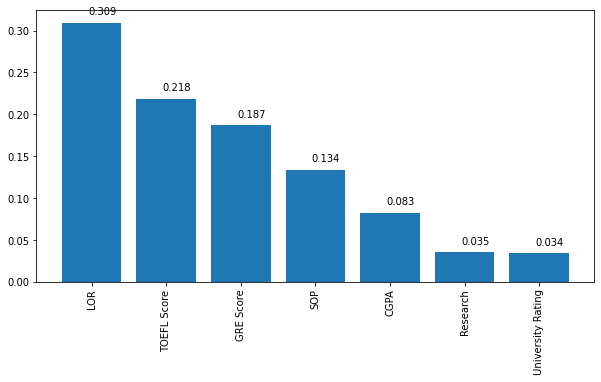

In [0]:
_,_ = draw_feature_importances( ab1, data2.loc[:, 'GRE Score':'Research'])

* Для оптимальной модели

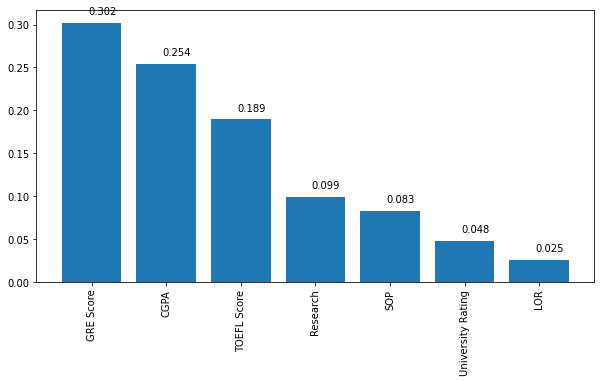

In [0]:
_,_ = draw_feature_importances( minMSE['model'], data2.loc[:, 'GRE Score':'Research'])

Примечательно то, что переменные `GRE Score` и `CGPA` обладают самыми высокими коэффициентами использования для построения оптимальной модели, также как и высокими коэффициентами корреляции к целевой переменной - `Chance of Admit`.


**Вывод:** Обе полученные модели обладают выской точностью. Более опти.мальная модель имеет показатели незначительно выше тестовой (например, СКО оптимальной модели меньше на 0.002 тестовой модели). Резюмируя вышесказанное, можно сказать, что построенная модель подходит для решения поставленной задачи.